# Integrating GPU libraries for fun and profit

### ...on extending and interfacing HPC simulation tools

##### Authors: Adrian Oeftiger and Martin Schwinzerl

# Abstract

I have a high-performance number crunching tool with cool physics which simulates long-term on a GPU &ndash; how can I extend the inner loop by further cool physics, injected from the outside?
In python this should be easy, right? But wait... we are sitting on device memory?

In this talk we explore how to tightly couple two libraries for high-performance computation of long-term beam dynamics, `SixTrackLib` and `PyHEADTAIL`. How can we design the _interface_ between both libraries in terms of

(1) remaining on the python level,

(2) avoid losing performance due to device-to-host-to-device copies, and

(3) keeping both libraries as stand-alone packages?

The interface can be surprisingly simple, yet fully fledged... Let's go!

# ... the Physics ...

# Collective beam dynamics

3D particle motion $\leadsto$ 6 phase space coordinates:
$$\mathbb{X}=(\underbrace{x, x'\vphantom{y'}}_{horizontal}, \underbrace{y, y'}_{vertical}, \underbrace{z, \delta\vphantom{y'}}_{longitudinal})$$

A beam $=$ state of $N$ macro-particles $=$ $6N$ values of phase space coordinates

## Simulations:
* typically up to $\mathcal{O}(10^6)$ macro-particles
* accelerator elements to track through: up to $\mathcal{O}(1000)$
* simulations can last up to $\mathcal{O}(10^6)$ turns 
* particle-to-particle interaction: binning, FFT, convolution, particle-in-cell, Poisson solvers

# Requirements for simulation tools

* long-term evolution $\leadsto$ **double precision**
* heavy **number crunching** $\leadsto$ high-performance computing (**HPC**)<br />(in particular for _collective effects_ i.e. particle-to-particle interaction)
* **iterative development**, frequent update of accelerator models $\leadsto$ python

# Single-particle vs. multi-particle dynamics

**single-particle** $\implies$ <span style="color:#00aad4;">"tracking"</span>: particle motion due to external focusing (magnets and RF cavities)

**multi-particle** $\implies$ <span style="color:#aa0000;">"collective effect kicks"</span>: direct and indirect particle-to-particle interaction

<center>
<img src="images/transverse-model_empty.png" alt="sketch of one-turn map for ring" style="width:30%;"/>
Tracking around the accelerator ring
</center>

# The `PyHEADTAIL` library

Python based code for simulating collective beam dynamics: [github repo $\nearrow$](https://github.com/PyCOMPLETE/PyHEADTAIL)

$\implies$ simplified matrix-based <span style="color:#00aad4;">tracking</span>

$\implies$ **strong:** detailed models for <span style="color:#aa0000;">collective effect kicks</span>

<center>
<img src="images/wakefield.png" alt="wake field sketch" style="width:30%;"/>
Example for a kick: wakefield induced by leading particles imparting kicks on trailing particles
</center>

# The `SixTrackLib` library

C templated code with Python API for simulating single-particle beam dynamics: [github repo $\nearrow$](https://github.com/sixtrack/sixtracklib)

$\implies$ **strong:** advanced non-linear <span style="color:#00aad4;">tracking</span>

$\implies$ approximative / simplified models for <span style="color:#aa0000;">collective effect kicks</span>

<center>
<img src="images/tracking.png" alt="tracking sketch" style="width:30%;"/>
Example for tracking: <span style="color:#ff6701;">dipole magnets bend</span> and <span style="color:#800000;">quadrupole magnets (de-)</span><span style="color:#000080;">focus</span> particles
</center>

# ... the HPC part ...

# `PyHEADTAIL` on the GPU

[Concept presented on PyHEP'19 $\nearrow$](https://indico.cern.ch/event/833895/contributions/3577801/), in short:

<div style="float: right; width: 10%">
<img src="images/duck.png" alt="duck typing" style="width: 100%;" /> <br />
<!-- <img src="pycuda-logo2.png" alt="PyCUDA logo" style="width: 100%;" /> -->
</div>

* utilise **duck typing** to separate physics from back-end implementation
* sandwich layer via **context management** and **function redirection**<br />(separate math dictionaries for CPU and GPU)
* exploit GPU via `PyCUDA` (`CuPy` would work similarly)

In [ ]:
# tracking loop in PyHEADTAIL:
with GPU(pyht_beam):
    for i in range(n_turns):
        for element in pyht_ring_elements:
            element.track(pyht_beam)

$\implies$ implement physics only once! <br />
$\implies$ back-end details transparent to users / high-level developers

# `SixTrackLib` on the GPU

[Concept presented on PyHEP'19 $\nearrow$](https://indico.cern.ch/event/833895/contributions/3577803/), in short:

* Python API for dynamic interaction
* C **templating approach** to separate physics from back-end implementation
    * implementation in usual C for (single-core) CPU
    * implementation in openCL for multi-core CPU and GPU (AMD, NVIDIA)
    * implementation in CUDA for NVIDIA GPUs

In [ ]:
# tracking kernel in SixTrackLib
trackjob = stl.TrackJob(stl_ring_elements, stl_beam, device='opencl:0.0')
trackjob.track_until(n_turns)

$\implies$ implement physics only once! <br />
$\implies$ users launch "trackjobs" with just a single `device` keyword to switch architecture

# ... the quest ...

# `SixTrackLib` $+$ `PyHEADTAIL` $=$ <3 ?

`SixTrackLib` $\rightarrow$ strong in advanced non-linear <span style="color:#00aad4;">tracking</span>

`PyHEADTAIL` $\rightarrow$ strong in <span style="color:#aa0000;">collective effect kicks</span>

$\implies$ `SixTrackLib` $+$ `PyHEADTAIL` $=$ strong in both?

<center>
<img src="images/transverse-model_integration.png" alt="integrating PyHEADTAIL and SixTrackLib" style="width:30%;"/>
Alternating SixTrackLib <span style="color:#00aad4;">tracking</span> and PyHEADTAIL <span style="color:#aa0000;">kicking</span>
</center>

# ... the quest*ions* ...

Situation:
* `PyHEADTAIL` on the GPU lives in `PyCUDA`, managed from user script
* `SixTrackLib` on the GPU manages its CUDA kernel invocation by itself
* beam state data: <br />`PyHEADTAIL` uses `PyCUDA.GPUArrays` while `SixTrackLib` uses custom memory buffers

Critical aspects:
* how to avoid GPU - CPU - GPU memory transfer?
* how to hand over the data between the two codes?
* can `PyHEADTAIL`'s `PyCUDA` context interact with `SixTrackLib`'s initialised context? 
    * visibility of memory to each other
    * alternating kernel calls?
    * flow control from python level?

# ... well &ndash; let's try to unify, shan't we?

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

Importing SixTrackLib:

In [2]:
import sixtracklib as stl

# print current commit
import os
stl_dir = os.path.dirname(stl.__file__)
!printf "SixTrackLib " && cd $stl_dir && git log | head -1

SixTrackLib commit f42c420da20602c9c4c08172338ed3019bb20d25


Importing PyHEADTAIL:

In [3]:
import sys
sys.path = ['/home/oeftiger/gsi/git/PyHEADTAIL/'] + sys.path

from pycuda.autoinit import context

import PyHEADTAIL

PyHEADTAIL v1.14.1.10




In [4]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.detuners import Chromaticity
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems

/home/oeftiger/anaconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [5]:
from scipy.constants import e, c, physical_constants

circumference = 1083.6
Q_x = 18.84
Q_y = 18.73
gamma = 1.215
charge = 28 * e
mass = 238 * physical_constants['atomic mass constant'][0]

transverse_map = TransverseMap(
    s=[0, 1], 
    alpha_x=[0] * 2, 
    beta_x=[circumference / (2 * np.pi * Q_x)] * 2, 
    D_x=[0] * 2, 
    alpha_y=[0] * 2, 
    beta_y=[circumference / (2 * np.pi * Q_y)] * 2, 
    D_y=[0] * 2,
    accQ_x=Q_x, 
    accQ_y=Q_y,
    detuners=[Chromaticity(Q_x, Q_y)],
)

longitudinal_map = RFSystems(
    circumference=circumference, 
    harmonic_list=[8],
    voltage_list=[58.2e3 * 100],
    phi_offset_list=[np.pi],
    alpha_array=[15.82**-2],
    gamma_reference=gamma,
    p_increment=0, 
    charge=charge,
    mass=mass,
)

In [6]:
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss

In [7]:
n_macroparticles = 100000
intensity = 6.25e10 * 2000
epsn_x = 6e-6
epsn_y = 2.5e-6
sigma_z = 58 / 4. * 0.2
sigma_dp = 0.5e-3 * 0.2 * 10

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles,
    intensity=intensity,
    charge=charge,
    mass=mass,
    circumference=circumference,
    gamma=gamma,
    beta_z=sigma_z / sigma_dp,
    epsn_x=epsn_x,
    epsn_y=epsn_y,
    epsn_z=sigma_z * sigma_dp * 4 * np.pi * longitudinal_map.get_bucket(gamma=gamma).p0 / e,
    limit_n_rms_x=3**2,
    limit_n_rms_y=3**2,
    limit_n_rms_z=3**2,
    **transverse_map.get_injection_optics(
        for_particle_generation=True),
)

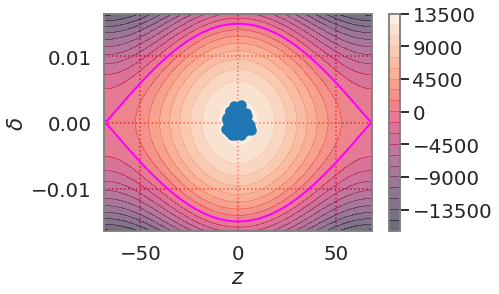

In [8]:
b = longitudinal_map.get_bucket(pyht_beam)
z = np.linspace(*b.interval, num=100)
dp = np.linspace(-b.dp_max(b.z_ufp) * 1.1, b.dp_max(b.z_ufp) * 1.1, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = b.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
plt.scatter(pyht_beam.z[::1000], pyht_beam.dp[::1000])
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [9]:
import matplotlib as mpl

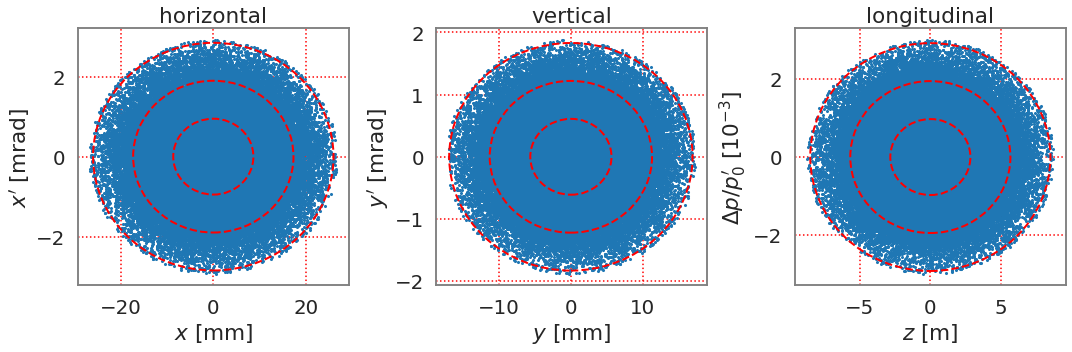

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal')

ep = mpl.patches.Ellipse(
    (0, 0), 2*pyht_beam.sigma_x() * 1e3, 2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 2*2*pyht_beam.sigma_x() * 1e3, 2*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 3*2*pyht_beam.sigma_x() * 1e3, 3*2*pyht_beam.sigma_xp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)

plt.scatter(pyht_beam.x * 1e3, pyht_beam.xp * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [mrad]")


plt.sca(ax[1])
plt.title('vertical')

ep = mpl.patches.Ellipse(
    (0, 0), 2*pyht_beam.sigma_y() * 1e3, 2*pyht_beam.sigma_yp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 2*2*pyht_beam.sigma_y() * 1e3, 2*2*pyht_beam.sigma_yp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 3*2*pyht_beam.sigma_y() * 1e3, 3*2*pyht_beam.sigma_yp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)

plt.scatter(pyht_beam.y * 1e3, pyht_beam.yp * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
plt.xlabel('$y$ [mm]')
plt.ylabel("$y'$ [mrad]")


plt.sca(ax[2])
plt.title('longitudinal')

ep = mpl.patches.Ellipse(
    (0, 0), 2*pyht_beam.sigma_z(), 2*pyht_beam.sigma_dp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 2*2*pyht_beam.sigma_z(), 2*2*pyht_beam.sigma_dp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)
ep = mpl.patches.Ellipse(
    (0, 0), 3*2*pyht_beam.sigma_z(), 3*2*pyht_beam.sigma_dp() * 1e3,
    lw=2, fill=False, color='red', zorder=20, ls='--')
plt.gca().add_patch(ep)

plt.scatter(pyht_beam.z, pyht_beam.dp * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0'$ [$10^{-3}$]")

plt.tight_layout()

In [11]:
from PyHEADTAIL.impedances.wakes import WakeField, ParallelHorizontalPlatesResonator
from PyHEADTAIL.particles.slicing import UniformBinSlicer

In [12]:
# resistive_wall_wake = ParallelHorizontalPlatesResistiveWall(
#     pipe_radius=3e-2 * 0.15,
#     resistive_wall_length=circumference,
#     conductivity=1.4e6,
#     dt_min=pyht_beam.sigma_z() / (1000 * pyht_beam.beta * c),
# )

resonator_wake = ParallelHorizontalPlatesResonator(
    R_shunt=7e6, frequency=1.5e9, Q=1,
)

slicer = UniformBinSlicer(n_slices=70, n_sigma_z=4)

wakefield = WakeField(slicer, resonator_wake)

In [13]:
slices = pyht_beam.get_slices(slicer)
1 / slices.convert_to_time(2 * 4 * pyht_beam.sigma_z()) * 70

526838563.1506717

In [14]:
1/(circumference/(pyht_beam.beta * c) / longitudinal_map.harmonics[0])

1257104.8758477094

In [15]:
pyht_ring_elements = list(transverse_map) + [longitudinal_map, wakefield]

In [16]:
pyht_beam.y += 0.1 * pyht_beam.sigma_y()

In [17]:
slices0 = pyht_beam.get_slices(slicer, statistics=['mean_y'])

In [18]:
from PyHEADTAIL.general.contextmanager import CPU, GPU
from PyHEADTAIL.general import pmath

In [19]:
# tracking loop in PyHEADTAIL:
n_turns = 1000

# transfer to GPU
with GPU(pyht_beam):
    my = pmath.zeros(n_turns, dtype=float)
    
    # loop over turns
    for i in range(n_turns):
        # loop over elements around ring
        for element in pyht_ring_elements:
            element.track(pyht_beam)

        # record vertical bunch centroid
        my[i] = pyht_beam.mean_y()

my = pmath.ensure_CPU(my)

In [20]:
slices = pyht_beam.get_slices(slicer, statistics=['mean_y'])

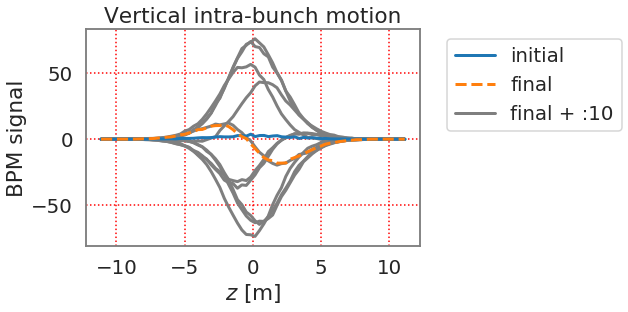

In [21]:
l1, = plt.plot(slices0.z_centers, slices0.mean_y * slices0.n_macroparticles_per_slice, zorder=3)
l2, = plt.plot(slices.z_centers, slices.mean_y * slices.n_macroparticles_per_slice, zorder=4, ls='--')

for i in range(10):
    for element in pyht_ring_elements:
        element.track(pyht_beam)
    slices = pyht_beam.get_slices(slicer, statistics=['mean_y'])
    l3, = plt.plot(slices.z_centers, slices.mean_y * slices.n_macroparticles_per_slice, color='C7')

plt.legend([l1, l2, l3], ['initial', 'final', 'final + :10'], 
           loc=2, bbox_to_anchor=(1.05, 1))
plt.xlabel('$z$ [m]')
plt.ylabel('BPM signal')
plt.title('Vertical intra-bunch motion');

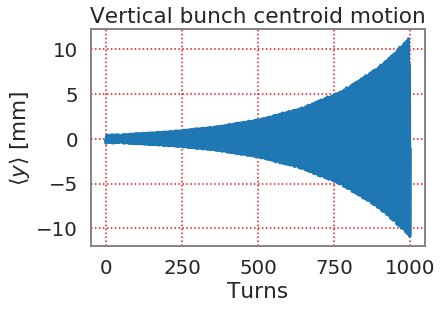

In [22]:
plt.plot(my * 1e3)
plt.xlabel('Turns')
plt.ylabel(r'$\langle y \rangle$ [mm]')
plt.title('Vertical bunch centroid motion');